# Hyperparameter Optimization for Random Forest Regression
A random forest regression model is fit and hyperparamters tuned. Several methods are examined by k-fold cross validation performed for each combination of parameter for tuning using GridSearch, RandomizedSearch, Bayesian optimization, and Genetic algorithm. The defualts and ranges for random forest regerssion hyperparameters will be the values we will attempt to optimize. Author: Marc Petta

### Set Up

In [ ]:
# set up
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import uniform, randint
from GPyOpt.methods import BayesianOptimization
from tpot import TPOTRegressor

### Data Preprocessing

In [1]:
# read data
df = pd.read_csv('diabetes.txt', sep=",")
# get col names
names = list(df.columns.values) 
# get predictors and assign to object
df1 = df.iloc[:,0:9]
# assign response to object
df2 = df.Y
# cast each as numpy array
X = pd.DataFrame(df1).to_numpy()
y = pd.DataFrame(df2).to_numpy()
#Split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


## Modeling

### Evaluation Function

In [ ]:
# function to evaluate and return values of r-squared, mean squared error, and plot of model accuracy
def my_regression_results(model):
    # assess model quality on test data
    score_test = model.score(X_test,y_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))
    # make predictions
    y_pred = model.predict(X_test)
    plt.plot(y_test,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');
    # assess accuracy on test-data.
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))

### Baseline 
For a baseline model to compare against alternative methods a linear regression will be fit on the training data using defualt values for hyperparameters. Model performance will be assessed on test data and returned from udf.

In [ ]:
# create a baseline model object declaring defualt values for hyperparameters
model_lr = LinearRegression()
# fit the model by calling its fit() method on the training set
model_lr.fit(X_train,y_train) # this could be inside the function below too    
my_regression_results(model_lr)

### Randon Forest Regression
Fit random forest regression an compare results

In [ ]:
# create a random forest regression model object declaring defualt values for hyperparameters
rf_model = RandomForestRegressor(random_state=0)
#Fit model and compare results 
rf_model.fit(X_train,y_train)
my_regression_results(rf_model)

We find no improvement over the linear regression model when applying defualts in Random Forest. Lets see if anything can be done about that.

Next, a look at the parameters of a random forest regression to determine if we are able to improve the model performance from above. We will preform k-fold cross validation for each combination of parameter for tuning using several methods. The defualts and ranges for random forest regerssion hyperparameters will be the values we will attempt to optimize.
#### GridSearch

In [ ]:
%%capture
# define the grid
params = {
    "n_estimators": [50, 100, 135],
    "max_features": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 8, 17],
    "min_samples_leaf": [1, 13, 18],
    "bootstrap": [True, False]
}

# setup the grid search
grid_search = GridSearchCV(rf_model,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)
# fit the model
grid_search.fit(X_train, y_train)

Take a look at the best parameters found by GridSearch

In [ ]:
# get best parameters found by GridSearch
grid_search.best_params_

The output above provides the best parameters found using GridSearch for optimization. Lets call our results function and see what we get.

In [ ]:
# get results for gridsearch
my_regression_results(grid_search)

Tuning hyperparameters with GridSearch shows improvement compared to the defualt random forest defualt model. Lets now proceed with the alternative methods.
#### RandomizedSearch

In [ ]:
# define the parameter ranges to optimize
params = {
    "n_estimators": randint(10, 150),
    "max_features": [0.05, 0.1, 0.25, 0.5, 0.75, 1.0],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "bootstrap": [True, False]
}
# setup the random search 
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    random_state=123,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)
# fit model
random_search.fit(X_train, y_train)

Take a look at the best parameters found by RandomizedSearch

In [ ]:
random_search.best_params_

Get results for comparison

In [ ]:
my_regression_results(random_search)

We will continue to examine alternative algorithms and provide a final comparative assessment.
#### Bayesian Optimization

In [2]:
# set seed for reproducability
np.random.seed(123)

# define the parameter ranges to optimize
hp_bounds = [{
    'name': 'n_estimators',
    'type': 'discrete',
    'domain': (10, 150)
}, {
    'name': 'max_features',
    'type': 'continuous',
    'domain': (0.05, 1.0)
}, {
    'name': 'min_samples_split',
    'type': 'discrete',
    'domain': (2, 20)
}, {
    'name': 'min_samples_leaf',
    'type': 'discrete',
    'domain': (1, 20)
}, {
    'name': 'bootstrap',
    'type': 'discrete',
    'domain': (True, False)
}]

# optimization objective
def cv_score(hyp_parameters):
    hyp_parameters = hyp_parameters[0]
    rf_model = RandomForestRegressor(random_state=0,
                                    n_estimators=int(hyp_parameters[0]),
                                    max_features=hyp_parameters[1],
                                    min_samples_split=int(hyp_parameters[2]),
                                    min_samples_leaf=int(hyp_parameters[3]),
                                    bootstrap=bool(hyp_parameters[4]))   
    scores = cross_val_score(rf_model,
                             X=X_train,
                             y=y_train,
                             cv=KFold(n_splits=5))
    return np.array(scores.mean())  # return average of 5-fold scores


optimizer = BayesianOptimization(f=cv_score,
                                 domain=hp_bounds,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 acquisition_jitter=0.05,
                                 exact_feval=True,
                                 maximize=True,
                                 verbosity=True)

optimizer.run_optimization(max_iter=20,verbosity=True)

num acquisition: 1, time elapsed: 0.79s
num acquisition: 2, time elapsed: 1.82s
num acquisition: 3, time elapsed: 1.98s
num acquisition: 4, time elapsed: 2.18s
num acquisition: 5, time elapsed: 2.38s
num acquisition: 6, time elapsed: 2.59s
num acquisition: 7, time elapsed: 2.78s
num acquisition: 8, time elapsed: 3.75s
num acquisition: 9, time elapsed: 4.73s
num acquisition: 10, time elapsed: 5.72s
num acquisition: 11, time elapsed: 6.75s
num acquisition: 12, time elapsed: 7.74s
num acquisition: 13, time elapsed: 8.82s
num acquisition: 14, time elapsed: 9.92s
num acquisition: 15, time elapsed: 11.03s
num acquisition: 16, time elapsed: 11.95s
num acquisition: 17, time elapsed: 12.21s
num acquisition: 18, time elapsed: 12.44s
num acquisition: 19, time elapsed: 12.64s
num acquisition: 20, time elapsed: 12.88s


Take a look at the best parameters found by Bayesion Optimization

In [3]:
# extract the coefficients
best_hyp_set = {}
for i in range(len(hp_bounds)):
    if hp_bounds[i]['type'] == 'continuous':
        best_hyp_set[hp_bounds[i]['name']] = optimizer.x_opt[i]
    else:
        best_hyp_set[hp_bounds[i]['name']] = int(optimizer.x_opt[i])
best_hyp_set

{'n_estimators': 10,
 'max_features': 0.5499949703940653,
 'min_samples_split': 2,
 'min_samples_leaf': 20,
 'bootstrap': 0}

Lets take those best coefficients and fit the best model and get results for comparison.

In [4]:
# fit model with coefficients from the previous Bayesian optimization
bayopt_search = RandomForestRegressor(random_state=0,**best_hyp_set)
bayopt_search.fit(X_train,y_train)

RandomForestRegressor(bootstrap=0, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5499949703940653,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

Model r-squared score from test data: 0.5155
Mean squared error on test data: 3052.38
Root mean squared error on test data: 55.25


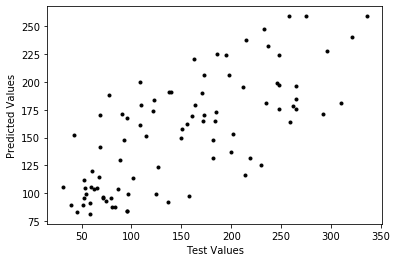

In [5]:
#compare results
my_regression_results(bayopt_search)

#### Genetic Algortithm
Try some hyperparameter optimization using a Genetic Algorithm from TPOT

In [ ]:
# define the parameter ranges to optimize
tpot_config = {
    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    }
}
# setup the genetic algorithm
tpot = TPOTRegressor(generations=5,
                     population_size=20,
                     verbosity=2,
                     config_dict=tpot_config,
                     cv=5,
                     scoring='r2',
                     random_state=123)
# fit the model
tpot.fit(X_train, y_train)

In [ ]:
# get results
my_regression_results(tpot)

### Conclusion

In [ ]:
# initialize list of lists 
data = [['BaseLine', 0.5261, 2985.88, 54.64, '-','-','-','-','-','-' ], ['GridSearch', 0.5575, 2787.80, 54.64 , 810, 50, 0.6, 2, 13, 'T'], ['RandomSearch', 0.5560, 2797.00, 52.89, 125, 74, 0.5, 7, 11, 'T'], ['Bayesian', 0.5155, 3052.38, 55.25, 125, 10, 0.55, 2, 20, 'F'], ['Genetic', 0.5597, 2774.18, 52.67, 600, 100, 0.3500, 8, 10, 'T']] 
  
# Create the pandas DataFrame 
dfinal = pd.DataFrame(data, columns = ['Name', 'r-squared', 'mean squared error', 'root mean squared error', 'model fits', 'n_estimators','max_features', 'min_samples_split', 'min_samples_leaf', 'bootstrap']) 
  
# print dataframe. 
dfinal 

What purpose this model is used for would ultimately determine which would be considered best. In terms of r-squared the table above illustrates Bayesian Optimization having performed better than the baseline random forest with defualt hyperparameters. If decreasing error in the model is paramount then we find that all alternative methods except Bayesian display lower values of mean squared error. As this is simply an illustration of procedure depending on application of the model the process above can help determine optimized hyperparameters. 